# Steady-state and transient thermal analysis for co-packaged optics

<img src="img/CPO.png" width="600" alt="ME">

The demand for ever higher input/output (I/O) bandwidths has driven the development of co-packaged optics (CPO), where optical components are integrated alongside the application-specific integrated circuit (ASIC). This approach enables higher transmission rates and lower energy consumption, helping to circumvent the packaging bottlenecks that limit next-generation communication devices.

A natural evolution is to bring the optics directly onto the silicon interposer, reducing the electrical distance between transmitter/receiver and ASIC. This tighter integration is particularly relevant for datacenters, high-performance computing (HPC) clusters, and AI systems, where switch bandwidth and energy efficiency are critical.

At the same time, chip power continues to rise, requiring increasingly complex cooling solutions. Thermal management becomes a central challenge, since temperature variations directly impact the performance of microring modulators and filters used in dense wavelength-division multiplexing (DWDM) links.

In this notebook, we illustrate how to set up a simplified 3D thermal simulation of a microring integrated on a silicon interposer, inspired by the paper of `Benjamin G. Lee, Nikola Nedovic, Thomas H. Greer, and C. Thomas Gray, "Beyond CPO: A Motivation and Approach for Bringing Optics Onto the Silicon Interposer", Journal of Lightwave Technology 41(4), 1152–1165 (2023).` [DOI: https://doi.org/10.1109/JLT.2022.3219379](https://doi.org/10.1109/JLT.2022.3219379).

The key steps are:

1) Define the material stack — silicon interposer, buried oxide, photonic layer, BEOL glass, copper heat spreader, and heaters.

2) Assign thermal properties — capacity, conductivity, and density for each material.

3) Set up boundary conditions — insulating boundaries, with thermal impedance applied at the top of the heat spreader.

4) Apply power perturbations — ASIC load steps and local heater power steps.

5) Run transient simulations — compute the time-dependent temperature distribution across the device.

6) Analyze results — observe the thermal response of the microring, neighbor coupling, and evaluate stabilization requirements for control loops.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

# Suppress warnings due to structure reaching boundaries, which can be disregarded for Heat simulations
td.config.logging_level = "ERROR"

## Simulation Setup

First we will define an auxiliary function to easily stack the different parts of the geometry.

In [2]:
def stack_box(
    structure_1,
    structure_2,
    plane="x",
    horizontal="right",
    vertical="top",
    gap_h=0,
    gap_v=0,
    new_name=None,
):
    """
    Aligns and stacks *structure_2* relative to *structure_1* in a given plane
    with configurable horizontal and vertical positioning.

    Parameters
    ----------
    structure_1 : tidy3d.Structure
        Tidy3D structure used as the base.
    structure_2 : tidy3d.Structure
        Tidy3D structure to be translated and stacked relative to *structure_1*.
    plane : str, optional
        Plane of alignment ('x', 'y', or 'z'). Default is 'x'.
    horizontal : str, optional
        Horizontal alignment relative to *structure_1* ('left', 'right', 'center').
        Default is 'right'.
    vertical : str, optional
        Vertical alignment relative to *structure_1* ('top', 'bottom', 'center').
        Default is 'top'.
    gap_h : float, optional
        Horizontal gap between structures. Default is 0.
    gap_v : float, optional
        Vertical gap between structures. Default is 0.
    new_name : str, optional
        Name for the updated *structure_2*. If None, retains original name.

    Returns
    -------
    tidy3d.Structure
        A copy of *structure_2* translated to the new aligned position.
    """

    box_1 = structure_1.geometry.bounding_box
    box_2 = structure_2.geometry.bounding_box

    c1 = np.array(box_1.center)
    c2 = np.array(box_2.center)

    s1 = np.array(box_1.size)
    s2 = np.array(box_2.size)

    # Default: new center is box_1 center
    new_center = c1.copy()

    # Which plane are we stacking in?
    axis = {"x": 0, "y": 1, "z": 2}[plane]
    aux = [0, 1, 2]
    aux.remove(axis)
    horizontal_axes = min(aux)
    vertical_axes = max(aux)

    for i in [(horizontal, horizontal_axes, gap_h), (vertical, vertical_axes, gap_v)]:
        if i[0] == "center":
            new_center[i[1]] = c1[i[1]]
        elif i[0] == "left":
            new_center[i[1]] = c1[i[1]] - s1[i[1]] / 2 + (s2[i[1]] / 2) + i[2]
        elif i[0] == "right":
            new_center[i[1]] = c1[i[1]] + s1[i[1]] / 2 - (s2[i[1]] / 2) + i[2]
        elif i[0] == "top":
            new_center[i[1]] = c1[i[1]] + s1[i[1]] / 2 + (s2[i[1]] / 2) + i[2]
        elif i[0] == "bottom":
            new_center[i[1]] = c1[i[1]] - s1[i[1]] / 2 - (s2[i[1]] / 2) - i[2]

    translated_geometry = structure_2.geometry.translated(
        x=-c2[0] + new_center[0], y=-c2[1] + new_center[1], z=-c2[2] + new_center[2]
    )

    return structure_2.updated_copy(
        geometry=translated_geometry, name=new_name if new_name else structure_2.name
    )

## Material properties

For heating simulations, we need to add a heat specification to the Tidy3D [MultiPhysicsMedium](https://docs.flexcompute.com/projects/tidy3d/en/v2.9.0/api/_autosummary/tidy3d.components.material.multi_physics.MultiPhysicsMedium.html) object via the `heat_spec` argument, defining the thermal material properties:  
- **Specific heat capacity** in J/(kg·K)  
- **Thermal conductivity** in W/(µm·K)  
- **Density** in kg/µm³, required for transient heat analysis

In [3]:
Si_n = 3.4777  # Si refractive index
Si_n_slope = 1.86e-4  # Si thermo-optic coefficient dn/dT [1/K]

Si_capacity = 710  # Si specific heat capacity [J/(kg·K)]
Si_conductivity = 148e-6  # Si thermal conductivity [W/(µm·K)]
Si_density = 2.33e-15  # Si density [kg/µm^3] (2330 kg/m^3)

freq0 = td.C_0 / 1.5

Si_optical = td.Medium.from_nk(n=Si_n, k=0, freq=freq0)
Si_heat = td.SolidSpec(capacity=Si_capacity, conductivity=Si_conductivity, density=Si_density)

Si = td.MultiPhysicsMedium(optical=Si_optical, heat=Si_heat, name="Si")

SiO2_n = 1.444  # SiO2 refractive index
SiO2_n_slope = 1e-5  # SiO2 thermo-optic coefficient dn/dT [1/K]

SiO2_capacity = 703  # SiO2 specific heat capacity [J/(kg·K)]
SiO2_conductivity = 1.38e-6  # SiO2 thermal conductivity [W/(µm·K)]
SiO2_density = 2.634e-15  # SiO2 density [kg/µm^3] (2634 kg/m^3)

# Alternative way of defining a medium specification
SiO2_optical = td.Medium(permittivity=SiO2_n**2)

SiO2_heat = td.SolidSpec(
    capacity=SiO2_capacity, conductivity=SiO2_conductivity, density=SiO2_density
)
SiO2 = td.MultiPhysicsMedium(optical=SiO2_optical, heat=SiO2_heat, name="SiO2")

Cu_capacity = 385  # Cu specific heat capacity [J/(kg·K)]
Cu_conductivity = 401e-6  # Cu thermal conductivity [W/(µm·K)]
Cu_density = 8.96e-15  # Cu density [kg/µm^3] (8960 kg/m^3)

Cu_optical = td.PECMedium()
Cu_heat = td.SolidSpec(capacity=Cu_capacity, conductivity=Cu_conductivity, density=Cu_density)

Cu = td.MultiPhysicsMedium(
    optical=Cu_optical,
    heat=Cu_heat,
    name="Cu",
)

# BEOL layer (modeled as porous SiO2 / low-k dielectric)
BEOL_capacity = 703  # J/(kg·K), similar to SiO2
BEOL_conductivity = 0.45e-6  # W/(µm·K), reduced effective conductivity
BEOL_density = 2.2e-15  # kg/µm^3, lower density due to porosity

beol_SiO2_optical = td.Medium(permittivity=SiO2_n**2)
beol_SiO2_heat = td.SolidSpec(
    capacity=BEOL_capacity,
    conductivity=BEOL_conductivity,
    density=BEOL_density,
)

beol_SiO2 = td.MultiPhysicsMedium(
    optical=beol_SiO2_optical,
    heat=beol_SiO2_heat,
    name="BEOL",
)

## Simulation Geometry

Next, we will define the different layers of the structure.  
The stack consists of:  

- **Copper heat spreader** on top, which serves as the main cooling interface.  
- **ASIC** (logic die), the primary heat source in the system.  
- **Plastic molding compound** as a thin spacer between the ASIC and the photonic layers.  
- **Photonic Integrated Circuit (PIC)** on the interposer surface, containing the microring resonators.  
 - **Buried oxide (BOX)** below the silicon waveguides, providing thermal and optical isolation.  
 - **BEOL glass** above the rings, insulating them from the electronic circuits.  
 - **Metal heaters** embedded in glass just above the rings for thermo-optic tuning.  
- **Silicon interposer** at the bottom.  

A schematic can be seen in the image below:

<img src="img/CPO2.png" width="600" alt="ME">

In [4]:
# Unit helpers (all geometry in µm)
mm = 1e3
width = 160 * mm

# Silicon interposer (bottom substrate, 100 µm thick in the paper)
interposer_thickness = 0.1 * mm
interposer_length = 10 * mm
Silicon_interposer = td.Structure(
    geometry=td.Box(
        center=(0, 0, -interposer_thickness / 2),
        size=(interposer_length, width, interposer_thickness),
    ),
    name="Silicon_interposer",
    medium=Si,
)

# ASIC die (logic die, ~1 mm thick)
asic_thickness = 1 * mm
asic_length = 5 * mm
ASIC_Die = td.Structure(
    geometry=td.Box(size=(asic_length, width, asic_thickness)),
    name="ASIC_Die",
    medium=Si,
)

# Plastic molding compound spacer between ASIC and PIC/EIC (~70 nm)
silicon_gap_thickness = 0.07  # 70 nm
silicon_gap_length = 10 * mm
Silicon_gap = td.Structure(
    geometry=td.Box(size=(silicon_gap_length, width, silicon_gap_thickness)),
    name="Molding_spacer",
    medium=SiO2,  # simple proxy; replace with a polymer if desired
)

# Optional placeholder “source region” (e.g., for heater or power injection)
Source = td.Structure(
    geometry=td.Box(size=(5 * mm, width, 0.01)),  # 10 nm
    name="Source",
    medium=Si,  # set to appropriate medium if used
)

# PIC die on interposer (photonic Si layer stack)
buried_sio2_thickness = 2  # µm (BOX)
beol_thickness = 10  # µm (BEOL glass)

# Photonic Si core (100 µm total PIC die; subtract BOX and BEOL to keep total)
pic_thickness = 0.1 * mm
pic_length = 5 * mm
PIC_Die = td.Structure(
    geometry=td.Box(
        size=(pic_length, width, pic_thickness - buried_sio2_thickness - beol_thickness)
    ),
    name="PIC_Die",
    medium=Si,
)

# Buried oxide (BOX) under the photonic Si
buried_sio2 = td.Structure(
    geometry=td.Box(size=(pic_length, width, buried_sio2_thickness)),
    name="buried_sio2",
    medium=SiO2,
)

# BEOL dielectric above the photonic Si (glass/low-k stack)
beol = td.Structure(
    geometry=td.Box(size=(pic_length, width, beol_thickness)),
    name="beol",
    medium=beol_SiO2,
)

# EIC die above the PIC (fills remaining thickness up to ~1 mm total)
eic_thickness = 1 * mm - pic_thickness
eic_length = pic_length
EIC_Die = td.Structure(
    geometry=td.Box(size=(eic_length, width, eic_thickness)),
    name="EIC_Die",
    medium=Si,
)

# Copper heat spreader on top (~0.5 mm)
heat_spreader_thickness = 0.5 * mm
heat_spreader_length = 10 * mm
Heat_spreader = td.Structure(
    geometry=td.Box(size=(heat_spreader_length, width, heat_spreader_thickness)),
    name="Heat_spreader",
    medium=Cu,
)


# Lateral gap placeholder
die_gap_thickness = asic_thickness
die_gap_length = 0.07  # 70 nm in x
Die_gap = td.Structure(
    geometry=td.Box(size=(die_gap_length, width, die_gap_thickness)),
    name="Die_gap_lateral",
    medium=SiO2,
)

# Stack the structures (using your helper `stack_box`)
ASIC_Die = stack_box(Silicon_interposer, ASIC_Die, plane="y", horizontal="right", vertical="top")
PIC_Die = stack_box(Silicon_interposer, PIC_Die, plane="y", horizontal="left", vertical="top")
buried_sio2 = stack_box(PIC_Die, buried_sio2, plane="y", horizontal="left", vertical="top")
beol = stack_box(buried_sio2, beol, plane="y", horizontal="left", vertical="top")
EIC_Die = stack_box(beol, EIC_Die, plane="y", horizontal="center", vertical="top")
Die_gap = stack_box(ASIC_Die, Die_gap, plane="y", horizontal="left", vertical="center")
Heat_spreader = stack_box(EIC_Die, Heat_spreader, plane="y", horizontal="left", vertical="top")

### Creating the [Scene](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Scene.html) Object

Next, we place the structures in a [Scene](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Scene.html) object and visualize the cross-section.

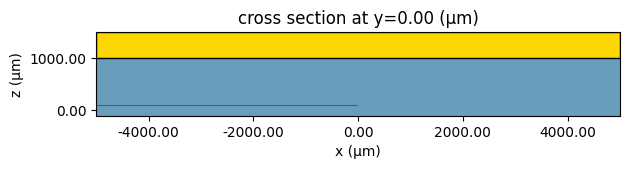

In [5]:
scene = td.Scene(
    structures=[
        Silicon_interposer,
        #  Silicon_gap,
        ASIC_Die,
        PIC_Die,
        EIC_Die,
        Die_gap,
        Heat_spreader,
        beol,
        buried_sio2,
    ]
)

ax = scene.plot(y=0)

plt.show()

### Defining Mesh

We will use a [UniformUnstructuredGrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.UniformUnstructuredGrid.html) object to create a uniform unstructured mesh. The *relative_min_dl* is set to a low value due to the small features in the geometry.

In [6]:
mesh = td.UniformUnstructuredGrid(dl=0.005 * mm, relative_min_dl=0.0003)

### Defining Source

Here, we will use a linear source at the bottom of the ASIC die. The [HeatSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatSource.html) object is assigned to the ASIC die structure, with a custom power distribution only at its bottom.

In [7]:
# Line heat source

x = np.linspace(0 * mm, 5 * mm, 100)
y = [0]
z = [0]

rate = 2 * (500 / 800) * 1e-9  # W/um^3
data = rate * np.ones((len(x), 1, 1))


coords = dict(x=x, y=y, z=z)
custom_rate = td.SpatialDataArray(data, coords=coords)

heat_source = td.HeatSource(structures=["ASIC_Die"], rate=custom_rate)  # W/um^3

### Defining Monitors

We will add a [TemperatureMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TemperatureMonitor.html) to track the temperature distribution across the simulation domain.

In [8]:
temp_mnt = td.TemperatureMonitor(
    size=(td.inf, 0, td.inf), name="temperature", unstructured=True, conformal=True
)

### Boundary Conditions

The boundary conditions are all insulating, except for the z+ boundary, which uses a [ConvectionBC](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ConvectionBC.html) with a heat impedance of $3\times10^7 \mu\text{m}^2\text{ K/W}$.

In [9]:
insulating = td.HeatBoundarySpec(
    condition=td.HeatFluxBC(flux=0),
    placement=td.SimulationBoundary(surfaces=["x+", "x-", "z-"]),
)

heat_impedance = 3e7  # µm^2 K/W

top_boundary = td.HeatBoundarySpec(
    condition=td.ConvectionBC(
        ambient_temperature=300,  # K
        transfer_coeff=1 / heat_impedance,  # W/(K*µm^2)
    ),
    placement=td.SimulationBoundary(surfaces=["z+"]),
)

## Steady Heat Simulation

First, we will assemble all components and create the [HeatChargeSimulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatChargeSimulation.html) object for the steady-state simulation.

We can see warnings regarding structures extending into the PML

In [10]:
heat_sim = td.HeatChargeSimulation(
    center=scene.center,
    size=scene.size,
    medium=scene.medium,
    structures=scene.structures,
    boundary_spec=[insulating, top_boundary],
    sources=[heat_source],
    grid_spec=mesh,
    monitors=[temp_mnt],
)

Finally, we can use [web.run](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.webapi.run.html) to upload the simulation to the cloud, run it, monitor progress, download the data, and load it into the [HeatChargeSimulationData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatChargeSimulationData.html) object for post-processing.

In [ ]:
steady_data = web.run(heat_sim, task_name="CPOHeat_Steady")

Output()

15:40:05 -03 loading simulation from simulation_data.hdf5

### Visualizing Steady-State Results

We can call the *.plot* method to visualize the field distribution in the simulation plane.  

As we can see, the thin plastic region provides good insulation for the ASIC die. For reference, the structures are highlighted in the figure on the right.

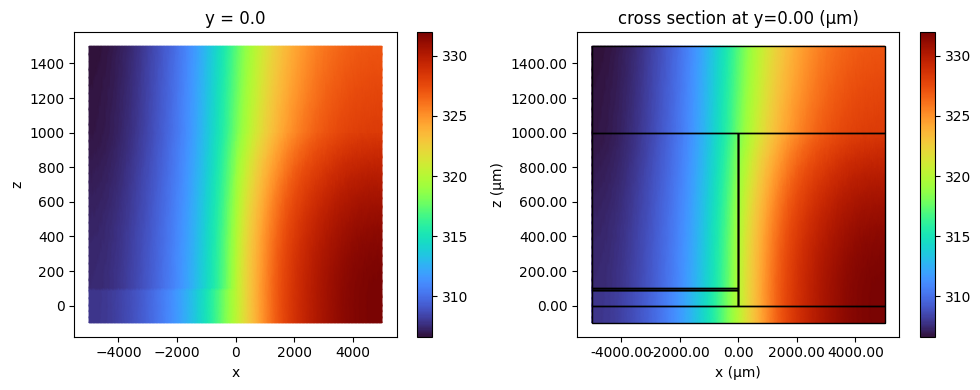

In [12]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 4))


steady_data["temperature"].temperature.plot(grid=False, ax=ax)
ax.set_aspect("auto")
ax.collections[-1].set_cmap("turbo")

steady_data["temperature"].temperature.plot(grid=False, ax=ax2)
scene.plot(y=0, ax=ax2, fill_structures=False)
ax2.set_aspect("auto")
ax2.collections[-1].set_cmap("turbo")

ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim())

plt.tight_layout()
plt.show()

## Transient Analysis

For transient heating analysis, the only modification is providing an [UnsteadyHeatAnalysis](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.UnsteadyHeatAnalysis.html) object to the `analysis_spec` parameter of the [HeatChargeSimulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.HeatChargeSimulation.html) model object, specifying the initial temperature, number of time steps, and step size.

We will reuse the previously created object and update it with the `updated_copy` method.

In [13]:
time_step_2d = 1e-3
total_time_steps_2d = 1000

time_spec = td.UnsteadyHeatAnalysis(
    initial_temperature=300,
    unsteady_spec=td.UnsteadySpec(
        time_step=time_step_2d,
        total_time_steps=total_time_steps_2d,
    ),
)

heat_sim_transient = heat_sim.updated_copy(analysis_spec=time_spec)

In [ ]:
heat_data_transient = web.run(heat_sim_transient, "CPO_2D_Transient")

Output()

15:40:28 -03 loading simulation from simulation_data.hdf5

### Visualizing Transient Results

Next we will visualize the results at typical resonator positions and at different points on the ASIC die.

/tmp/ipykernel_427248/680229564.py:14: RuntimeWarning: divide by zero encountered in log10
  Ax[0].plot(np.log10(time_steps), temp1.values.squeeze(), color="purple", label="PIC 1")
/tmp/ipykernel_427248/680229564.py:15: RuntimeWarning: divide by zero encountered in log10
  Ax[0].plot(np.log10(time_steps), temp2.values.squeeze(), color="red", label="PIC 2")
/tmp/ipykernel_427248/680229564.py:16: RuntimeWarning: divide by zero encountered in log10
  Ax[0].plot(np.log10(time_steps), temp3.values.squeeze(), color="lightgreen", label="ASIC left edge")
/tmp/ipykernel_427248/680229564.py:17: RuntimeWarning: divide by zero encountered in log10
  Ax[0].plot(np.log10(time_steps), temp4.values.squeeze(), color="orange", label="ASIC 1 mm from PIC")
/tmp/ipykernel_427248/680229564.py:18: RuntimeWarning: divide by zero encountered in log10
  Ax[0].plot(np.log10(time_steps), temp5.values.squeeze(), color="blue", label="ASIC 5 mm from PIC")


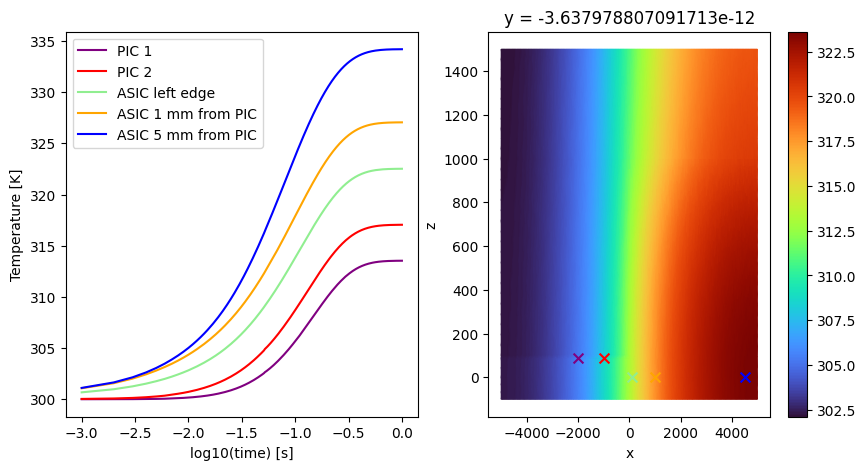

In [15]:
fig, Ax = plt.subplots(1, 2, figsize=(10, 5))

PIC_z = buried_sio2.geometry.bounding_box.center[2]

temp1 = heat_data_transient["temperature"].temperature.sel(x=-2000, z=PIC_z, method="nearest")
temp2 = heat_data_transient["temperature"].temperature.sel(x=-1000, z=PIC_z, method="nearest")
temp3 = heat_data_transient["temperature"].temperature.sel(x=100, z=0, method="nearest")
temp4 = heat_data_transient["temperature"].temperature.sel(x=1000, z=0, method="nearest")
temp5 = heat_data_transient["temperature"].temperature.sel(x=4500, z=0, method="nearest")


time_steps = time_step_2d * np.arange(total_time_steps_2d)

Ax[0].plot(np.log10(time_steps), temp1.values.squeeze(), color="purple", label="PIC 1")
Ax[0].plot(np.log10(time_steps), temp2.values.squeeze(), color="red", label="PIC 2")
Ax[0].plot(np.log10(time_steps), temp3.values.squeeze(), color="lightgreen", label="ASIC left edge")
Ax[0].plot(np.log10(time_steps), temp4.values.squeeze(), color="orange", label="ASIC 1 mm from PIC")
Ax[0].plot(np.log10(time_steps), temp5.values.squeeze(), color="blue", label="ASIC 5 mm from PIC")
Ax[0].set_xlabel("log10(time) [s]")
Ax[0].set_ylabel("Temperature [K]")
Ax[0].legend()

_ = heat_data_transient["temperature"].temperature.sel(t=99).plot(grid=False, ax=Ax[1])
Ax[1].set_aspect("auto")
Ax[1].collections[-1].set_cmap("turbo")
Ax[1].scatter(-2000, PIC_z, color="purple", s=50, marker="x")
Ax[1].scatter(-1000, PIC_z, color="red", s=50, marker="x")
Ax[1].scatter(100, 0, color="lightgreen", s=50, marker="x")
Ax[1].scatter(1000, 0, color="orange", s=50, marker="x")
Ax[1].scatter(4500, 0, color="blue", s=50, marker="x")

plt.show()

## 3D Transient Simulation

Now we will investigate the effect of the heater on neighboring resonators.  

A localized power step is applied to one microring heater, and the transient temperature response is computed in 3D.  
This allows us to observe the ring’s heating dynamics and quantify thermal crosstalk with adjacent resonators.

### Defining the Ring and Heater Geometry

In [16]:
# Ring center (aligned above the buried oxide layer)
mrr_center = (
    -2000,
    0,
    buried_sio2.geometry.bounding_box.center[2] + buried_sio2.geometry.bounding_box.size[2] / 2,
)

# Heater placed 1 µm above the ring center in z
heater_center = (mrr_center[0], mrr_center[1], mrr_center[2] + 1)

# Ring dimensions (radius = 20 µm, width = 1 µm)
ring_radius = 20
ring_width = 1

# Ring geometry defined as a hollow cylinder (outer – inner cylinder)
ring_geometry = td.Cylinder(
    center=heater_center, radius=ring_radius, length=0.22, axis=2
) - td.Cylinder(center=heater_center, radius=ring_radius - ring_width, length=0.22, axis=2)

# Define first microring (Si core)
ring1 = td.Structure(geometry=ring_geometry, medium=Si, name="ring")

# Define heater overlapping the ring geometry (Cu)
heater1 = td.Structure(geometry=ring_geometry, medium=Cu, name="heater")

# Place heater above ring1 with a vertical gap of 1 µm
heater1 = stack_box(
    ring1, heater1, plane="y", horizontal="center", vertical="top", gap_v=1, new_name="heater1"
)

# Duplicate ring1 to create a neighboring ring at 100 µm horizontal separation
ring2 = stack_box(
    ring1, ring1, plane="y", horizontal="left", vertical="center", gap_h=100, new_name="ring2"
)

# Place heater above the second ring with the same 1 µm gap
heater2 = stack_box(
    ring2, heater1, plane="y", horizontal="center", vertical="top", gap_v=1, new_name="heater2"
)

The new source is a uniform source located right next to the resonator's heater.

In [17]:
# Line heat source

x = np.linspace(0 * mm, 5 * mm, 100)
y = [0]
z = [0]

power = 5e-3  # 1 mW
volume = 0.22 * np.pi * (ring_radius**2 - (ring_radius - ring_width) ** 2)  # um^3
rate = power / volume  # W/um^3

heat_source3 = td.HeatSource(structures=["heater1"], rate=rate)  # W/um^3

Now we can place the geometry and new source together and update the 2D simulation.

In [18]:
scene_3d = scene.updated_copy(structures=list(scene.structures) + [ring1, heater1, ring2, heater2])

center_3d = mrr_center
size_3d = (1 * mm,) * 3

heat_sim_3d = heat_sim.updated_copy(
    center=center_3d, size=size_3d, structures=scene_3d.structures, sources=[heat_source3]
)

First, let's visualize the geometry:

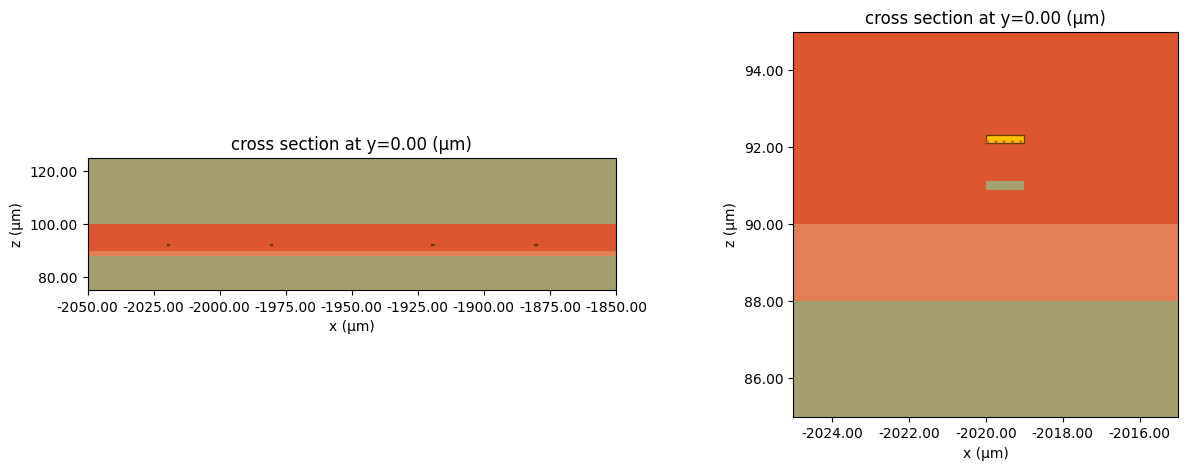

In [19]:
fig, Ax = plt.subplots(1, 2, figsize=(15, 5))
ax1 = heat_sim_3d.plot(y=0, ax=Ax[0])
ax1.set_xlim(-2050, -1850)
ax1.set_ylim(75, 125)

ax2 = heat_sim_3d.plot(y=0, ax=Ax[1])
ax2.set_xlim(-2025, -2015)
ax2.set_ylim(85, 95)
# ax2.set_aspect('auto')}

plt.show()

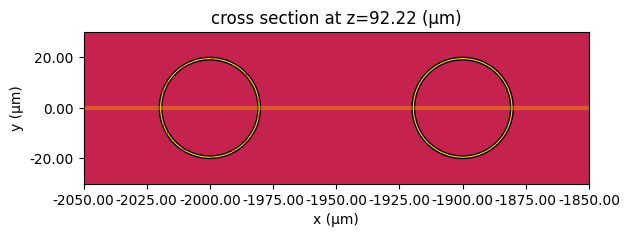

In [20]:
ax = heat_sim_3d.plot(z=heater2.geometry.bounding_box.center[2])
ax.set_xlim(-2050, -1850)
ax.set_ylim(-30, 30)

plt.show()

### 3D Transient Analysis

Next, we will create an [UnsteadyHeatAnalysis](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.UnsteadyHeatAnalysis.html) object for the 3D analysis and run the simulation.

In [21]:
time_step = 1e-6
total_time_steps = 1000

time_spec = td.UnsteadyHeatAnalysis(
    initial_temperature=300,
    unsteady_spec=td.UnsteadySpec(
        time_step=time_step,
        total_time_steps=total_time_steps,
    ),
)

heat_sim_transient_3d = heat_sim_3d.updated_copy(analysis_spec=time_spec)

In [ ]:
heat_data_transient_3d = web.run(heat_sim_transient_3d, "CPO_3D_Transient")

Output()

15:40:45 -03 loading simulation from simulation_data.hdf5

### Visualizing Temperature Distribution

We can now visualize the heat distribution in the heated and neighboring resonators. The crosstalk is very small and can only be seen when saturating the temperature values in the figure on the right.

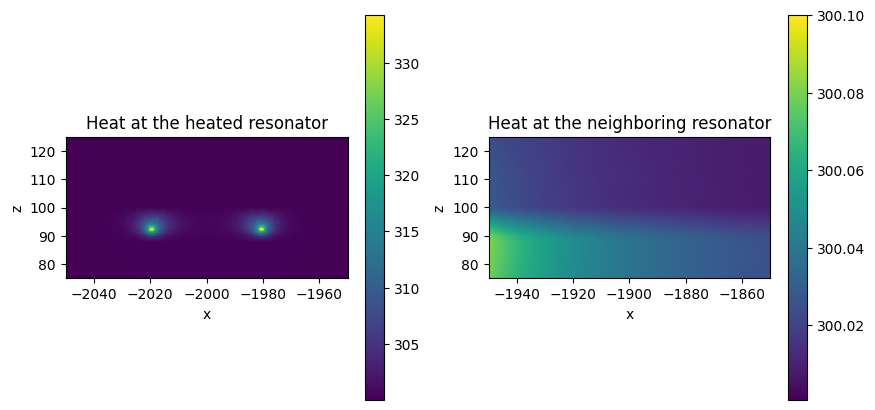

In [23]:
fig, Ax = plt.subplots(1, 2, figsize=(10, 5))

ax1 = heat_data_transient_3d["temperature"].temperature.sel(t=999).plot(grid=False, ax=Ax[0])
ax1.set_xlim(-2050, -1950)
ax1.set_ylim(75, 125)
ax1.set_title("Heat at the heated resonator")
ax2 = (
    heat_data_transient_3d["temperature"]
    .temperature.sel(t=999)
    .plot(grid=False, ax=Ax[1], vmax=300.1)
)
ax2.set_xlim(-1950, -1850)
ax2.set_ylim(75, 125)
ax2.set_title("Heat at the neighboring resonator")

plt.show()

Finally, we can analyze the heat dynamics. As we can see, the heated resonator transient response follows closely the heater, while the neighboring resonator shows only a small temperature rise with a noticeable delay.  

This analysis is important for understanding thermal crosstalk between adjacent devices and for defining the requirements for stabilization and control loops that keep the microrings properly tuned.

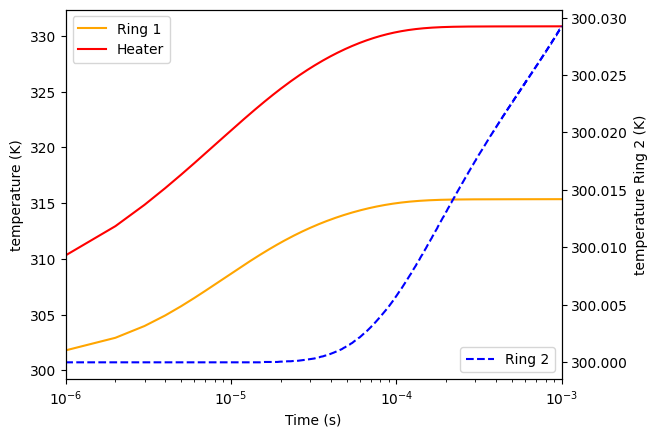

In [24]:
# Coordinates for sampling temperatures
x_ring_1 = ring1.geometry.bounding_box.center[0] + 19  # sample point near ring radius
y_ring_1 = ring1.geometry.bounding_box.center[1]  # same y as ring center
z_ring_1 = ring1.geometry.bounding_box.center[2]  # same z as ring center

# Temperature at Ring 1
temp_ring1 = heat_data_transient_3d["temperature"].temperature.sel(
    x=x_ring_1,
    y=y_ring_1,
    z=z_ring_1,
)

# Temperature at Ring 2 (100 µm away in x)
temp_ring2 = heat_data_transient_3d["temperature"].temperature.sel(
    x=x_ring_1 + 100, y=y_ring_1, z=z_ring_1, method="nearest"
)

# Temperature at Heater (1 µm above Ring 1)
temp_heater1 = heat_data_transient_3d["temperature"].temperature.sel(
    x=x_ring_1, y=y_ring_1, z=z_ring_1 + 1, method="nearest"
)

# Plot transients
fig, ax = plt.subplots()

time = time_step * np.arange(total_time_steps)

# Plot Ring 1 and Heater on the primary y-axis
ax.plot(time, temp_ring1.squeeze(), "-", label="Ring 1", color="orange")
ax.plot(time, temp_heater1.squeeze(), "-", label="Heater", color="red")
ax.set_ylabel("temperature (K)")
ax.set_xlabel("Time (s)")
ax.set_xscale("log")
ax.set_xlim(1e-6, 1e-3)
ax.legend(loc=2)

# Plot Ring 2 on a secondary y-axis for clarity
ax2 = ax.twinx()
ax2.plot(time, temp_ring2.squeeze(), "--", label="Ring 2", color="blue")
ax2.set_ylabel("temperature Ring 2 (K)")
ax2.legend(loc=4)


plt.show()